In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *

from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

In [21]:
runlist = np.arange(166, 175, 1)
#runlist = [790, 791, 792]
Loaddir = '../Claudio/Reduced_XANES_timescans/'
##############################################3
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 9 runs: [166 167 168 169 170 171 172 173 174] from ../Claudio/Reduced_XANES_timescans/


## check data files

In [22]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*timescan*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
datafiles      

[166 167 168 169 170 171 172 173 174]
20 files found


['../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_Delay_fs.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_Delay_fm.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_goodshots1.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_DataDiode1_pump.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_DataDiode1_unpump.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_Pump_probe_Diode1.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_goodshots2.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_DataDiode2_pump.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001/timescan_DataDiode2_unpump.npy',
 '../Claudio/Reduced_XANES_timescans/run0166-FePhen_timescan_7119p5eV_001

# Plotting timescans WITHOUT timetool
## (for TT correction go below)

In [23]:
diode_array = ['timescan_DataDiode1_pump', 'timescan_DataDiode1_unpump', 'timescan_Pump_probe_Diode1',
               'timescan_DataDiode2_pump', 'timescan_DataDiode2_unpump', 'timescan_Pump_probe_Diode2']

for spec in diode_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    patch = datafiles
    #spec2save = 0
    spec2save = []
    for ff in patch:
        spec2save.append(np.load(ff, allow_pickle=True))
    #spec2save = np.average(temp,axis = 0)
    print (len(patch), spec, np.shape(spec2save))
    np.save(Loaddir+spec+'_all.npy', spec2save)

2 timescan_DataDiode1_pump (2, 56, 3)
2 timescan_DataDiode1_unpump (2, 56, 3)
2 timescan_Pump_probe_Diode1 (2, 56, 3)
2 timescan_DataDiode2_pump (2, 56, 3)
2 timescan_DataDiode2_unpump (2, 56, 3)
2 timescan_Pump_probe_Diode2 (2, 56, 3)


In [24]:
DataDiode1_pump_all = np.load(Loaddir+'/timescan_DataDiode1_pump_all.npy')
DataDiode1_unpump_all = np.load(Loaddir+'/timescan_DataDiode1_unpump_all.npy')
Pump_probe1_all = np.load(Loaddir+'/timescan_Pump_probe_Diode1_all.npy')
DataDiode2_pump_all = np.load(Loaddir+'/timescan_DataDiode2_pump_all.npy')
DataDiode2_unpump_all = np.load(Loaddir+'/timescan_DataDiode2_unpump_all.npy')
Pump_probe2_all = np.load(Loaddir+'/timescan_Pump_probe_Diode2_all.npy')

# ONE diode

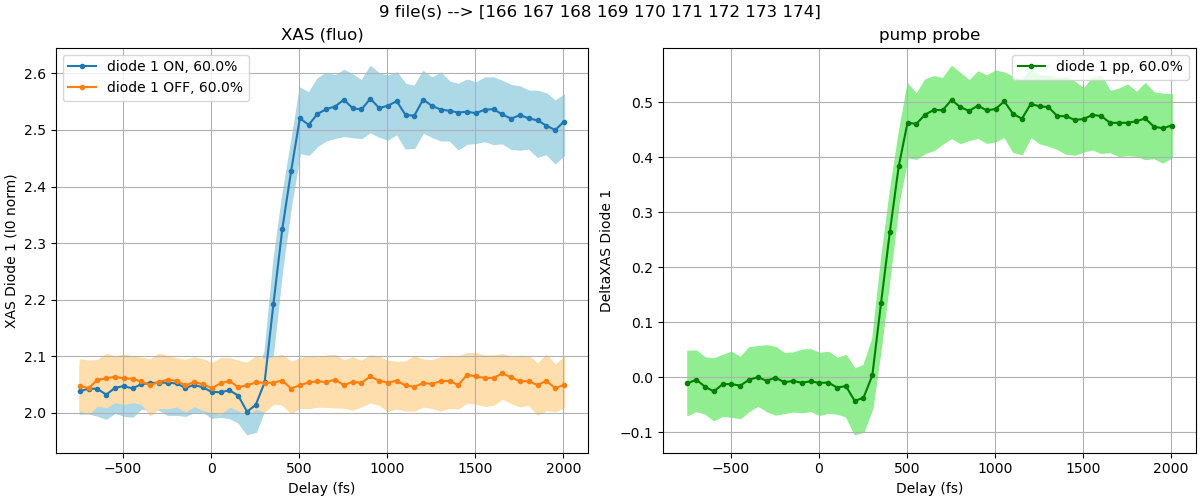

In [25]:
quantile_corr = 0.6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

XAS1_pump = np.mean(DataDiode1_pump_all, axis=0)[:,0]
err1_low_pump = np.mean(DataDiode1_pump_all, axis=0)[:,1]
err1_high_pump = np.mean(DataDiode1_pump_all, axis=0)[:,2]
XAS1_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,0]
err1_low_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,1]
err1_high_unpump = np.mean(DataDiode1_unpump_all, axis =0)[:,2]
XAS1_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,0]
err1_low_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,1]
err1_high_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,2]

ff = glob.glob(Loaddir+'/*{}*/timescan_Delay_fs.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])


#ax3 = ax1.twinx()

ax1.plot(Energy_eV, XAS1_pump, label='diode 1 ON, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS1_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax2.plot(Energy_eV, XAS1_pump_probe, label='diode 1 pp, {}%'.format(quantile_corr*100),marker='.', color='g')
ax2.fill_between(Energy_eV, err1_low_pump_probe, err1_high_pump_probe, color='lightgreen')


ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("DeltaXAS Diode 1")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

#ax1.legend(loc='best')
#ax2.legend(loc='lower right')
#ax1.set_xlabel('Energy (eV)')
#ax1.set_ylabel('XAS norm')
#ax2.set_ylabel('difference')
#ax1.grid()
plt.show()

# TWO diodes

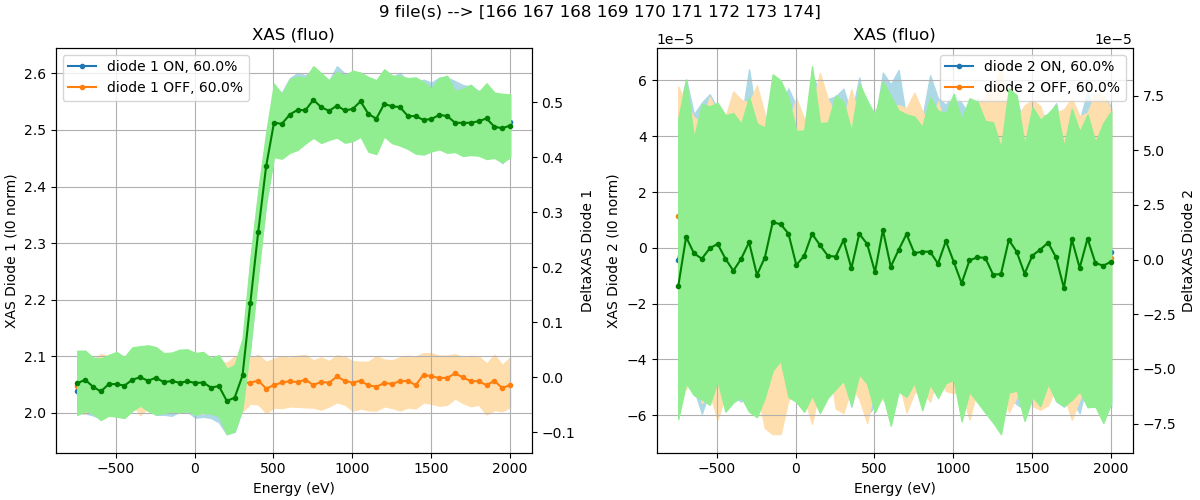

In [26]:
quantile_corr = 0.6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

XAS1_pump = np.mean(DataDiode1_pump_all, axis=0)[:,0]
err1_low_pump = np.mean(DataDiode1_pump_all, axis=0)[:,1]
err1_high_pump = np.mean(DataDiode1_pump_all, axis=0)[:,2]
XAS1_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,0]
err1_low_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,1]
err1_high_unpump = np.mean(DataDiode1_unpump_all, axis =0)[:,2]
XAS1_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,0]
err1_low_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,1]
err1_high_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,2]

XAS2_pump = np.mean(DataDiode2_pump_all, axis=0)[:,0]
err2_low_pump = np.mean(DataDiode2_pump_all, axis=0)[:,1]
err2_high_pump = np.mean(DataDiode2_pump_all, axis=0)[:,2]
XAS2_unpump = np.mean(DataDiode2_unpump_all, axis=0)[:,0]
err2_low_unpump = np.mean(DataDiode2_unpump_all, axis=0)[:,1]
err2_high_unpump = np.mean(DataDiode2_unpump_all, axis =0)[:,2]
XAS2_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,0]
err2_low_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,1]
err2_high_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,2]

ff = glob.glob(Loaddir+'/*{}*/timescan_Delay_fs.npy'.format(runlist[0]))
Delay_fs = np.load(ff[0])

ax3 = ax1.twinx()

ax1.plot(Energy_eV, XAS1_pump, label='diode 1 ON, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS1_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax3.plot(Energy_eV, XAS1_pump_probe, label='diode 1 pp, {}%'.format(quantile_corr*100),marker='.', color='g')
ax3.fill_between(Energy_eV, err1_low_pump_probe, err1_high_pump_probe, color='lightgreen')


ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax4 = ax2.twinx()

ax2.plot(Energy_eV, XAS2_pump, label='diode 2 ON, {}%'.format(quantile_corr*100),marker='.')
ax2.fill_between(Energy_eV, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Energy_eV, XAS2_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),marker='.')
ax2.fill_between(Energy_eV, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax4.plot(Energy_eV, XAS2_pump_probe, label='diode 2 pp, {}%'.format(quantile_corr*100),marker='.', color='g')
ax4.fill_between(Energy_eV, err2_low_pump_probe, err2_high_pump_probe, color='lightgreen')

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("XAS Diode 2 (I0 norm)")
ax4.set_ylabel ("DeltaXAS Diode 2")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

#ax1.legend(loc='best')
#ax2.legend(loc='lower right')
#ax1.set_xlabel('Energy (eV)')
#ax1.set_ylabel('XAS norm')
#ax2.set_ylabel('difference')
#ax1.grid()
plt.show()